# Homework 3 Part 2

## Course Name: Deep Learning
#### Lecturers: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Khoramnejad, Mehran Sarmadi, Zahra Rahimi

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


#Text Generation

<p align='justify'>Text generation task involves generating new text based on a given input or a prompt. It is a natural language processing (NLP) task that aims to generate coherent and contextually relevant text.

In text generation, a model is trained on a large corpus of text data and learns the patterns and structures of the language. This model can then be used to generate new text by sampling from the learned distribution of words or characters.

Text generation has various applications, including chatbots, language translation, poetry generation, and content creation. It can be implemented using different techniques such as `recurrent neural networks (RNNs)`, `transformers`, and `Markov chains`.

The goal of text generation is to produce text that is fluent, coherent, and contextually relevant. It requires a deep understanding of the language and the ability to generate text that follows grammatical rules and maintains semantic coherence.</p>

##Charachter-level text generation

One stage of the task of text generation is mapping, which can be at the word or character level. At this stage, a number is assigned to each word or character.

In this exercise, we generate text at the character level. Because generating text at the word level, even though it leads to more meaningful outputs, requires a rich dataset with a high number of word repetitions.

We will implement models based on `recurrent networks` for text generation and compare the performance of different models. In the following, we will check the performance of the best models on different datasets and compare the results

The steps of this exercise are as follows:
1. Train RNN and LSTM
2. FineTuning
3. Experiment on different datasets

---
---

#1. Train RNN and LSTM

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
import pandas as pd
import random
import re
import string

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load data

- We use the dataset of `Shakespeare's plays` as the main dataset for this exercise

In [ ]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt" -c -P {'data/'}

--2023-12-08 13:14:32--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘data/input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-12-08 13:14:32 (29.1 MB/s) - ‘data/input.txt’ saved [1115394/1115394]



- Load data in amout of 30kb for training models

In [ ]:
sh_data_file = "./data/input.txt"
sh_data = open(sh_data_file, 'r').read(30000)

##Charachter mapping

- For better performance of the model, we limit the set of allowed characters

In [ ]:
chars = list(string.ascii_lowercase + '\n' + ' ' + ':' + '.')
vocab_size = len(chars)

In [ ]:
# Mapping of char-index
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

##Preprocessing

In [ ]:
def remove_extraneous_characters(data, valid_char_list):
    pattern = f"[^{re.escape(''.join(valid_char_list))}]"
    return re.sub(pattern, '', data)

In [ ]:
sh_data = remove_extraneous_characters(sh_data.lower(), chars)
sh_data_size = len(sh_data)
sh_data = list(sh_data)
for i, ch in enumerate(sh_data):
    sh_data[i] = char_to_ix[ch]

sh_data = torch.tensor(sh_data).to(device)
sh_data = torch.unsqueeze(sh_data, dim=1)

In [ ]:
revised_input = torch.zeros(sh_data.shape[0],30)
for i in range(sh_data.shape[0]):
    revised_input[i][sh_data[i][0]] = 1
sh_data = revised_input
sh_data.to(device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
def print_sample_output(model, data, data_size, test_output_len = 200):


    test_output = ""
    data_ptr = 0

    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]
        input_seq = torch.zeros(1,30).to(device)
        input_seq[0][index] = 1
        data_ptr += 1

        if data_ptr > test_output_len:
            break

    print("Train Sample +++++++++++++++++++++++++++++++++++++++++++++")
    print(test_output)
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

##Modeling

- In this part define RNN and LSTM model, according to the mentioned characteristics and function inputs.


###RNN

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout_enable=False):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.1)
        self.init_hidden()



        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, dropout=0.5 if self.dropout_enable else 0, batch_first=True)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)

    def init_hidden(self):
        self.hidden_state = torch.zeros(self.num_layers, self.hidden_size).to(device)

    def forward(self, input_seq):
        input_seq = input_seq.float()
        out, self.hidden_state = self.rnn(input_seq, self.hidden_state)

        out = self.decoder(out.squeeze())

        return out

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))


###LSTM

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.4)
        self.hidden_state = None


        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):

        lstm_out, _ = self.lstm(input_seq, self.hidden_state)
        out = self.decoder(lstm_out[:,])
        return out

    def init_hidden(self):

        return (
            torch.zeros(self.num_layers, self.hidden_size).to(device),
            torch.zeros(self.num_layers, self.hidden_size).to(device)
        )

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))


##Training

In [ ]:

def train_epoch(model, data, data_size, epoch, optimizer, seq_len=200):

    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    sample_number = 0


    window = data_size - seq_len
    for index in range(0, window , seq_len):

        inputs = data[index:index+seq_len].to(device)
        lables = data[index+1:index+seq_len+1].to(device)
        model.init_hidden()

        outputs = model(inputs)
        loss = criterion(outputs, lables)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        sample_number = sample_number+1

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / (sample_number+1)}")


    return total_loss / (sample_number+1)

- For construction of each sample in the dataset, the output sequence is
obtained from the shift of one character from the input sequence. For example, when sequence_length is 10 and our text is `Hello world`. The input sequence would be `Hello worl`, and the target sequence `ello world`.

In [ ]:
import torch.optim as optim

def train_rnn(data, data_size, model_save_file):

    hidden_size = 512
    input_size = 30
    output_size = 30
    num_layers = 3
    lr = 0.002
    epoch_num = 100
    losses = []


    rnn_model = RNN(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=True).to(device)

    optimizer = optim.Adam(rnn_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()


    best = {'loss': float('inf')}

    for epoch in range(1, epoch_num + 1):
        print(f"Epoch: {epoch}")
        loss = train_epoch(rnn_model, data, data_size, epoch, optimizer)
        losses.append(loss)

        if loss < best['loss']:
            print(f"New best loss: {loss}")
            best['loss'] = loss
            torch.save(rnn_model.state_dict(), model_save_file)

    return losses

In [ ]:
def train_lstm(data, data_size, model_save_file):

    hidden_size = 512
    num_layers = 3
    lr = 0.002
    epoch_num = 100
    losses = []
    input_size = 30
    output_size = 30


    lstm = LSTM(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=True).to(device)


    optimizer = optim.Adam(lstm.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best = {'loss': float('inf')}

    for epoch in range(1, epoch_num + 1):
        print(f"Epoch: {epoch}")
        loss = train_epoch(lstm, data, data_size, epoch, optimizer)
        losses.append(loss)

        if loss < best['loss']:
            print(f"New best loss: {loss}")
            best['loss'] = loss
            torch.save(lstm.state_dict(), model_save_file)

    return losses

### RNN

In [ ]:
rnn_sh_losses = train_rnn(sh_data, sh_data_size, './model_sh_rnn2.pth')

Epoch: 1
New best loss: 3.0370884741822333
Epoch: 2
New best loss: 3.0139265533995956
Epoch: 3
New best loss: 3.0123755474613136
Epoch: 4
New best loss: 3.010600589726069
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
New best loss: 3.007477536593398
Epoch: 14
New best loss: 3.0055815699982316
Epoch: 15
New best loss: 3.0048325910960156
Epoch: 16
New best loss: 3.0047505767378087
Epoch: 17
New best loss: 3.004279077869572
Epoch: 18
Epoch: 19
New best loss: 3.0038030033242213
Epoch: 20
Epoch 20, Loss: 3.0242414458044644
New best loss: 3.0035274632989544
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
New best loss: 3.001802517943186
Epoch: 34
New best loss: 3.000813221278256
Epoch: 35
New best loss: 3.0002490020778083
Epoch: 36
New best loss: 2.9990103506062127
Epoch: 37
New best loss: 2.998738357465561
Epoch: 38
Epoch: 39
Epoch: 40
Epoch 40, Loss: 3.046894507572569
Ep

### LSTM

In [ ]:
lstm_sh_losses = train_lstm(sh_data, sh_data_size, './model_sh_lstm.pth')

Epoch: 1
New best loss: 2.7896797852973414
Epoch: 2
New best loss: 2.2517983529665697
Epoch: 3
New best loss: 1.9953578539090613
Epoch: 4
New best loss: 1.7983870212345907
Epoch: 5
New best loss: 1.640400380304415
Epoch: 6
New best loss: 1.5043137302137402
Epoch: 7
New best loss: 1.3810440036531997
Epoch: 8
New best loss: 1.2672181709171975
Epoch: 9
New best loss: 1.1328695575668388
Epoch: 10
New best loss: 1.005123538513706
Epoch: 11
New best loss: 0.8695683242523506
Epoch: 12
New best loss: 0.7301494311796476
Epoch: 13
New best loss: 0.6205371642765933
Epoch: 14
New best loss: 0.5264987655698437
Epoch: 15
New best loss: 0.4434885423477382
Epoch: 16
New best loss: 0.37363261157927447
Epoch: 17
New best loss: 0.30222617885837816
Epoch: 18
New best loss: 0.2687231051186993
Epoch: 19
New best loss: 0.24026578205497298
Epoch: 20
Epoch 20, Loss: 0.2333057019217261
New best loss: 0.23170771766198825
Epoch: 21
New best loss: 0.22704464697266277
Epoch: 22
New best loss: 0.21164390557024576
Ep

##Generating texts

- A sample text to input the model

In [ ]:
input_sample_text = 'First Citizen:\nYou are all resolved rather to die than to famish?\n'

def create_input_sample_dataset(input_sample_text):
    input_sample = remove_extraneous_characters(input_sample_text.lower(), chars)
    input_sample = list(input_sample)
    for i, ch in enumerate(input_sample):
        input_sample[i] = char_to_ix[ch]

    input_sample = torch.tensor(input_sample).to(device)
    input_sample = torch.unsqueeze(input_sample, dim=1)
    seq = torch.zeros(len(input_sample), 30).to(device)
    seq[torch.arange(len(input_sample)), input_sample] = 1
    return seq

- This function generates the output generated by the model for the input sample, and if the input sample text is not given, it samples a sequence of original data and gives it to the model.

In [ ]:
def generate_text(model, data, data_size, input_sample_test = None, output_len=1000):
    model.eval()
    data_ptr = 0
    test_output=""

    if input_sample_test is not None:
        index = 0
        seq_len = len(input_sample_test)
        input_seq = input_sample_test[index : index + seq_len-1]
    else:

        index = np.random.randint(data_size - 11)
        seq_len = 10
        input_seq = data[index : index + 9]


    output = model(input_seq)

    if input_sample_test is not None:
        input_seq = input_sample_test[index + seq_len-1 : index + seq_len]
    else:
        input_seq = data[index + seq_len-1 : index + seq_len]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]
#
        input_seq = torch.zeros(1,30).to(device)
        input_seq[0][index] = 1

        data_ptr += 1

        if data_ptr  > output_len:
            break

    print("Eaxmple of generated text --------------------------------------------------------------------------")
    print(test_output)
    print("----------------------------------------------------------------------------------------------------")

In [ ]:
def generate_text_additional(model, data, data_size, input_sample_test = None, output_len=1000):
    model.eval()
    data_ptr = 0
    test_output=""

    if input_sample_test is not None:
        index = 0
        seq_len = len(input_sample_test)
        input_seq = input_sample_test[index : index + seq_len-1]
    else:

        index = np.random.randint(data_size - 11)
        seq_len = 10
        input_seq = data[index : index + 9]


    output = model(input_seq)


    if input_sample_test is not None:
        input_seq = input_sample_test[index + seq_len-1 : index + seq_len]
    else:
        input_seq = data[index + seq_len-1 : index + seq_len]

    while True:
        output = model(input_seq.to(dev))

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]
        input_seq = torch.zeros(1,30).to(device)
        input_seq[0][index] = 1

        data_ptr += 1

        if data_ptr  > output_len:
            break

    print("Eaxmple of generated text --------------------------------------------------------------------------")
    print(test_output)
    print("----------------------------------------------------------------------------------------------------")

### RNN

In [ ]:
best_model_rnn =  RNN(vocab_size, vocab_size, 512, 3).to(device)
best_model_rnn.load_model('./model_sh_rnn2.pth')
print("best loss", min(rnn_sh_losses))
generate_text(best_model_rnn.to(device), sh_data.to(device), sh_data_size)


best loss 2.9911631313088822
Eaxmple of generated text --------------------------------------------------------------------------
aryfwgotrwatlt setaweecbbbinthl dfebo  uoho onoah:a  
wligruii
 aniuino
 ltethiuea:sshioonfeu  teudo 
aeo abrrd r
h
dhiceaomh
ieehdpzwisoeortioarduidiaaoii  pesete ebeah yeone.ta rv gyoi  oton u 
inossn.  bose.rlieedim trm sonpnhui
e oierut a seoohsyloi ociftl ne .t.ef es:
ou odneawhohyer
y oai euibshro aonor
n h mgtbn swmdcotoaa   ds  rwree 
sinnnea  ohmacrngne r hrubdc
omrnf 
 rtorr
suiruothwcenacytiaaffntnr  nrn
n.hen  etrnd u
inyiea  m:mrero

ewuea eul idto
.htsioowiho
 mfnvluai euetneohoernisel 

hoe 
 tditcoartsberiw: orreo  pchimihia iehosoelldhtdotg
o
eeilshineriuls n mehouhtdteyo eetnlmtc  yrmp dos   tlseu  ym ai aloriieuldin hov oinnhdleuinrns
lim wltttai:mh horh elyln o i  ioui h mtl aleturim . fyc ueroa ri rneeocekovra. sbyll  iwhghohwvdlel
a nkre bco znebaas  tia: e snyeahrdtae. oh
 
 d ttefsltoa  lcohrnyhseeuaa cilehtaonwtohihta ty  a  peitsaa


### LSTM

In [ ]:
dev = torch.device('cpu')

In [ ]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_lstm.pth')
print("best loss", min(lstm_sh_losses))
generate_text_additional(best_model_lstm.to(dev), sh_data.to(dev), sh_data_size)

best loss 0.016120025666019153
Eaxmple of generated text --------------------------------------------------------------------------
 o paro whto m shi pldi po.
vy kero soro s bls pld s o lusi s s mi by.
arbli o s plersi sus:
acle o o lsi o o m s pllsi o bllerble o o po m s s o orbe i ke pi o o o si o o si o po o ly o o whi o ifo o mi o ble o plersi s o s:
vy s o po i o pls:
arbly i o hi di s o s hersi o o s sirsi si ifaro o o m o bifage po mi he o o s ply plerodi o anandi o ply d o o ly o o o i mi di orblen o o ou s o s:
mi d ke plle po si mars by so o di hi s si hi hty w ls: s i ly.
vy wey.
ai s m pldi oudi s ple bley ke i whaifablurerbli s:
aro ley.
vy s le li po hi o ls ld o wert hi o o mi po lifan whi so ke m si m o o mi ply ly he o blsi serblsi suple hi ply.
acld o di o si wi pld plso herevy po mi lendifablers shable a o o o habso hi d surbls bly o sifacly m o o o s:
vy se po mi o o aly o o o aro ousi mi o s d lerbley o a ke hi blero di o prorto hifo plus plerere kerbld pls po m o

## Plotting the losses

In [ ]:
def plot_losses(losses):
    xpoints = np.array(range(len(losses)))
    ypoints = np.array(losses)

    plt.plot(xpoints, ypoints, color='blue',label='losses')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

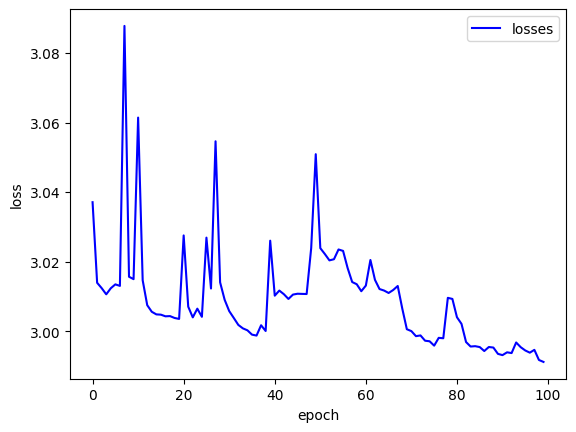

In [ ]:
plot_losses(rnn_sh_losses)

### LSTM

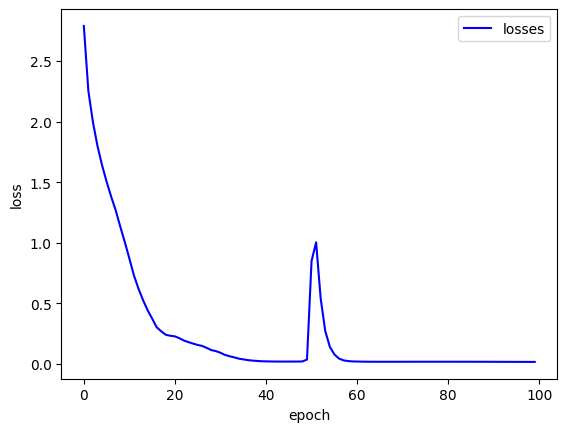

In [ ]:
plot_losses(lstm_sh_losses)

## Report

According to the texts generated from different models and the losses during the training process of the models, analyze what is the reason for the difference in the result of models.

Which model works better and what do you think are the reasons?

<font color='#73FF73'><b>Your answer : </b></font>LSTMs possess a sophisticated memory cell architecture, which encompasses distinct memory cells and a gating system. They are engineered to adeptly seize and regulate long-term dependencies, rendering them more efficient in situations where preserving data across extended sequences is vital. LSTMs encompass a greater number of parameters compared to RNNs. This is the reason why LSTMs outperform RNNs.

---
---

#2. FineTuning

FineTuning is a technique used in neural network training where a pre-trained model is further trained on a new task or dataset. It allows us to leverage the knowledge and representations learned by a pre-trained model and adapt it to a specific task or domain.

In this exercise, we first train the models with a `wikipedia` dataset that contains english texts, then we fine-tune this pre-trained model again with the Shakespeare play dataset to check the effect of this method on different models.

## Load Wikipedia dataset

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz

--2023-12-08 13:29:06--  https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.222.176, 52.217.73.214, 52.216.216.112, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.222.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070055 (3.9M) [application/x-tar]
Saving to: ‘wikitext-2.tgz.1’

wikitext-2.tgz.1    100%[===================>]   3.88M  8.81MB/s    in 0.4s    

2023-12-08 13:29:07 (8.81 MB/s) - ‘wikitext-2.tgz.1’ saved [4070055/4070055]



In [ ]:
!tar -xvzf '/kaggle/working/wikitext-2.tgz' -C '/kaggle/working'

tar (child): /kaggle/working/wikitext-2.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
!cat '/kaggle/working/wikitext-2/train.csv' | tr -d '\n' > ./data/wikitext.txt

cat: /kaggle/working/wikitext-2/train.csv: No such file or directory


##Preprocessing

In [ ]:
def clean_wiki_data(data):
    repl=''
    data=re.sub('\(', repl, data)
    data=re.sub('\)', repl, data)
    for pattern in set(re.findall("=.*=",data)):
        data=re.sub(pattern, repl, data)
    for pattern in set(re.findall("<unk>",data)):
        data=re.sub(pattern,repl,data)
    for pattern in set(re.findall(r"[^\w ]", data)):
        repl=''
        if pattern=='-':
            repl=' '
        if pattern!='.' and pattern!="\'":
            data=re.sub("\\"+pattern, repl, data)

    return data

def load_data(filepath):
    f=open(filepath)
    return f.read()

In [ ]:
wikidata=load_data("./data/wikitext.txt")
data=wikidata[:]
data=clean_wiki_data(data)
wikiPreprocessed_file = open("./data/wiki_preprocesed.txt", "w")
f = wikiPreprocessed_file.write(data)
wikiPreprocessed_file.close()

- Load data in amount of 50kb for finetuning

In [ ]:
wi_data_file = "./data/wiki_preprocesed.txt"
wi_data = open(wi_data_file, 'r').read(50000)

In [ ]:
wi_data = remove_extraneous_characters(wi_data.lower(), chars)
wi_data_size = len(wi_data)

wi_data = list(wi_data)
for i, ch in enumerate(wi_data):
    wi_data[i] = char_to_ix[ch]

wi_data = torch.tensor(wi_data).to(device)
wi_data = torch.unsqueeze(wi_data, dim=1)

In [ ]:
revised_input = torch.zeros(wi_data.shape[0],30)
for i in range(wi_data.shape[0]):
    revised_input[i][wi_data[i][0]] = 1



## Pre-training by wikipedia dataset

### RNN

In [ ]:
rnn_wi_losses = train_rnn(revised_input, wi_data_size, './model_wi_rnn.pth')

Epoch: 1
New best loss: 0.0
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch 20, Loss: 0.0
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch 40, Loss: 0.0
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch 60, Loss: 0.0
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch 80, Loss: 0.0
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91


### LSTM

In [ ]:
lstm_wi_losses = train_lstm(revised_input, wi_data_size, './model_wi_lstm.pth')

Epoch: 1
New best loss: 0.0
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch 20, Loss: 0.0
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch 40, Loss: 0.0
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch 60, Loss: 0.0
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch 80, Loss: 0.0
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91


## Finetuning by Shakespeare

- Define the following functions to use the previous model as a pre-trained model and fine-tunes it using Shakespeare's plays dataset with lower learning rate.

In [ ]:
def finetune_rnn(data, data_size, model_save_file, model_pretrained_path):

    hidden_size = 512
    num_layers = 3
    lr = 0.001
    epoch_num = 100
    losses = []

    rnn =  RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    rnn.load_model(model_pretrained_path)
    optimizer = optim.Adam(rnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best = {'loss': float('inf')}

    for epoch in range(1, epoch_num + 1):
        print(f"Epoch: {epoch}")
        loss = train_epoch(rnn, data, data_size, epoch, optimizer)
        losses.append(loss)

        if loss < best['loss']:
            print(f"New best loss: {loss}")
            best['loss'] = loss
            torch.save(rnn.state_dict(), model_save_file)

    return losses

In [ ]:
def finetune_lstm(data, data_size, model_save_file, model_pretrained_path):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.001
    epoch_num = 100
    losses = []


    lstm =  LSTM(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    lstm.load_model(model_pretrained_path)
    optimizer = optim.Adam(lstm.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')

    best = {'loss': float('inf')}

    for epoch in range(1, epoch_num + 1):
        print(f"Epoch: {epoch}")
        loss = train_epoch(lstm, data, data_size, epoch, optimizer)
        losses.append(loss)

        if loss < best['loss']:
            print(f"New best loss: {loss}")
            best['loss'] = loss
            torch.save(lstm.state_dict(), model_save_file)

    return losses

### RNN

In [ ]:
rnn_sh_finetune_losses = finetune_rnn(sh_data, sh_data_size, './model_sh_finetune_rnn.pth', './model_wi_rnn.pth')

Epoch: 1
New best loss: 2.5131685439854454
Epoch: 2
New best loss: 2.203711054096483
Epoch: 3
New best loss: 2.0467276483365935
Epoch: 4
New best loss: 1.9173606152403844
Epoch: 5
New best loss: 1.807242307760944
Epoch: 6
New best loss: 1.71989564128118
Epoch: 7
New best loss: 1.6610696764841473
Epoch: 8
New best loss: 1.6198181060895527
Epoch: 9
New best loss: 1.5844225050651863
Epoch: 10
New best loss: 1.5532219614068123
Epoch: 11
New best loss: 1.5128179845744616
Epoch: 12
New best loss: 1.4712223279966068
Epoch: 13
New best loss: 1.4212095419021502
Epoch: 14
New best loss: 1.3828811220926782
Epoch: 15
New best loss: 1.3473169815866914
Epoch: 16
New best loss: 1.2943555463666785
Epoch: 17
New best loss: 1.2694266262936265
Epoch: 18
New best loss: 1.2444116656910884
Epoch: 19
New best loss: 1.1941791870822644
Epoch: 20
Epoch 20, Loss: 1.1557121285020489
New best loss: 1.1557121285020489
Epoch: 21
New best loss: 1.105940099448374
Epoch: 22
New best loss: 1.092995869786772
Epoch: 23
Ne

### LSTM

In [ ]:
lstm_sh_finetune_losses = finetune_lstm(sh_data, sh_data_size, './model_sh_finetune_lstm.pth', './model_wi_lstm.pth')

Epoch: 1
New best loss: 2.9529666018812626
Epoch: 2
New best loss: 2.5557982709309828
Epoch: 3
New best loss: 2.183101026162709
Epoch: 4
New best loss: 1.9933610052278596
Epoch: 5
New best loss: 1.8417481820877284
Epoch: 6
New best loss: 1.715362014019326
Epoch: 7
New best loss: 1.5983064044011783
Epoch: 8
New best loss: 1.4867717868661228
Epoch: 9
New best loss: 1.3888598308987814
Epoch: 10
New best loss: 1.2913216372875318
Epoch: 11
New best loss: 1.180022173548398
Epoch: 12
New best loss: 1.060013661645863
Epoch: 13
New best loss: 0.9357607303416893
Epoch: 14
New best loss: 0.8208682614646546
Epoch: 15
New best loss: 0.7066293442494249
Epoch: 16
New best loss: 0.5998398281940042
Epoch: 17
New best loss: 0.508492406508694
Epoch: 18
New best loss: 0.4213296109682893
Epoch: 19
New best loss: 0.3444414114298886
Epoch: 20
Epoch 20, Loss: 0.2823282831335721
New best loss: 0.2823282831335721
Epoch: 21
New best loss: 0.24694480236670743
Epoch: 22
New best loss: 0.21024026262433562
Epoch: 23

## Plotting Losses

In [ ]:
def plot_losses_together(losses1, losses2):
    xpoints = np.array(range(len(losses1)))
    ypoints1 = np.array(losses1)
    ypoints2 = np.array(losses2)

    plt.plot(xpoints, ypoints1, color='blue',label='base_losses' )
    plt.plot(xpoints, ypoints2, color='red',label='finetune_losses' )
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

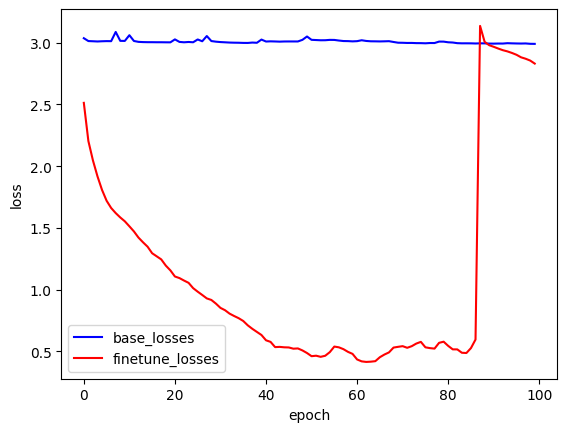

In [ ]:
plot_losses_together(rnn_sh_losses, rnn_sh_finetune_losses)

### LSTM

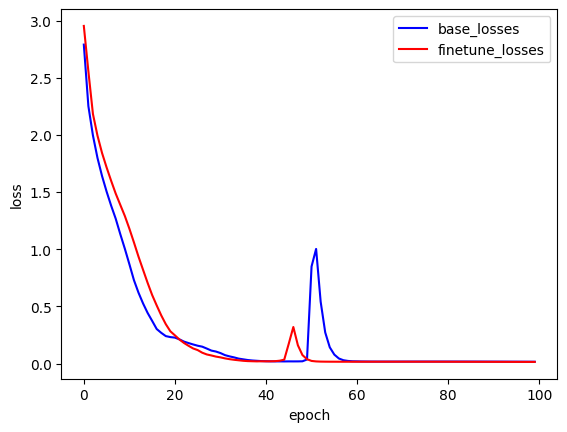

In [ ]:
plot_losses_together(lstm_sh_losses, lstm_sh_finetune_losses)

## Report

As you can see, fine-tuning has an effect in improving the training of the main model.

By analyzing the obtained results, state the advantage of finetuning after pre-training the model by public dataset, and compare its performance in different models

<font color='#73FF73'><b>Your answer : </b></font>The process of fine-tuning capitalizes on the insights acquired by a model that has been pre-trained on a substantial dataset, and applies this knowledge to a new, potentially smaller dataset. This strategy proves especially beneficial when the new task has scarce labeled data, as the pre-trained model contributes broad knowledge gleaned from a distinct yet associated task. It’s clear that fine-tuning has enhanced the model’s performance.

----
----

#3. Experiment on different datasets

In the previous section, you saw the performance results of the text generation model using the Shakespeare plays dataset. In the following, you will check the results of the LSTM model on the dialogues of the `Friends series`

## Load dataset

In [ ]:
!wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv -O ./data/Friends.csv

--2023-12-08 13:41:54--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5383844 (5.1M) [text/plain]
Saving to: ‘./data/Friends.csv’

./data/Friends.csv  100%[===================>]   5.13M  --.-KB/s    in 0.06s   

2023-12-08 13:41:54 (92.2 MB/s) - ‘./data/Friends.csv’ saved [5383844/5383844]



## preprocessing

In [ ]:
friends = pd.read_csv('./data/Friends.csv')
friends = friends.dropna()
friends = friends[friends['speaker'].str.contains('SCENE')==False]
friends['speaker'] = friends['speaker'].apply(lambda sp: sp.lower().capitalize().split(' ')[0])
friends_texts = friends.drop(['episode','season','scene','utterance'], axis='columns')
friends_texts.head()

,text,speaker
0,There's nothing to tell! He's just some guy I ...,Monica
1,"C'mon, you're going out with the guy! There's ...",Joey
2,"All right Joey, be nice. So does he have a hum...",Chandler
3,"Wait, does he eat chalk?",Phoebe
4,"(They all stare, bemused.)",Scene


In [ ]:
f = open("./data/fiends.txt", "w")
for i,row in friends_texts.iterrows():
    f.write(row['speaker'] + ':\n' + row['text'] + '\n\n')

f.close()

In [ ]:
fr_data_file = "./data/fiends.txt"
fr_data = open(fr_data_file, 'r').read(30000)
fr_data = remove_extraneous_characters(fr_data.lower(), chars)
fr_data_size = len(fr_data)

fr_data = list(fr_data)
for i, ch in enumerate(fr_data):
    fr_data[i] = char_to_ix[ch]

fr_data = torch.tensor(fr_data).to(device)
fr_data = torch.unsqueeze(fr_data, dim=1)

In [ ]:
revised_input = torch.zeros(fr_data.shape[0],30)
for i in range(fr_data.shape[0]):
    revised_input[i][fr_data[i][0]] = 1
revised_input.shape

torch.Size([28651, 30])

## Train finetuned LSTM by friends dataset

In [ ]:
lstm_fr_finetune_losses = finetune_lstm(revised_input, fr_data_size, './model_fr_lstm.pth', './model_wi_lstm.pth')

Epoch: 1
New best loss: 3.000496514969402
Epoch: 2
New best loss: 2.4460866186353893
Epoch: 3
New best loss: 2.0499328126509986
Epoch: 4
New best loss: 1.8477880987856123
Epoch: 5
New best loss: 1.689639561706119
Epoch: 6
New best loss: 1.5736354274882212
Epoch: 7
New best loss: 1.476461221774419
Epoch: 8
New best loss: 1.3755326407651107
Epoch: 9
New best loss: 1.2860090902282133
Epoch: 10
New best loss: 1.1948291982213657
Epoch: 11
New best loss: 1.0966790434386995
Epoch: 12
New best loss: 0.9947223688165346
Epoch: 13
New best loss: 0.8898273710575368
Epoch: 14
New best loss: 0.7860309096674124
Epoch: 15
New best loss: 0.6925450513760248
Epoch: 16
New best loss: 0.5987975812620587
Epoch: 17
New best loss: 0.5252489830470748
Epoch: 18
New best loss: 0.45796477649774814
Epoch: 19
New best loss: 0.3925653455985917
Epoch: 20
Epoch 20, Loss: 0.32538007644729483
New best loss: 0.32538007644729483
Epoch: 21
New best loss: 0.27412295972721445
Epoch: 22
New best loss: 0.23109300724334186
Epoc

## Generating texts

In [ ]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(dev)
best_model_lstm.load_model('./model_fr_lstm.pth')
print("best loss", min(lstm_fr_finetune_losses))
generate_text_additional(best_model_lstm, revised_input, fr_data_size)

best loss 0.014140986328129657
Eaxmple of generated text --------------------------------------------------------------------------
 kisis:

os:



ysscalis r:

r:


yorer:
ys:



m......
m... t ki
o
m. t a hidalidasit tsirerem.

o

o

raus:

o
o
rerem.. amo m... to
cass



yo
re teth m...... bedamontonnnt nt ca rennt h wed nnt nte tos rem.. m........ t reyoscatemo
ys:
o s th het rete t be mo t camossca ts:
o
ossu thant s:
onnnnnnthidau t t annntelat te ted r:
yo


o rs:
os has tt remo






os:

mo
m..
ont att ttt tt t cauyo
os:





osi d kis be annnnteremos:


mos:

yo
m.

o m.. t toft te to
m.... tteys h remoscantthem... ascamo asscas:
o ber:
mosis:
r:
oft casid m.... i

o
o tontts
o


reyscat bem... m. cannnnntoscasi
montosis nnttt r:
monthirem...... tt mouyo towidannnt tsca nnwed halasscas h t scauscatssnnt nt s ttoft am.....
reyoft t annt r:
o t re tetts:
mosis:
rscannt ttenntennnnnnt t t annnnto ters:
yo t tent mo a tto kir:
yo
mo

o
onnnt red cascalis m... retet annnnnnnnnne m

- As you can see, the LSTM network has been able to learn the features of different datasets in terms of sentence length and writing style and use it in text generation.

## The output of finetuned models on different datasets on the input sample

- In this section, you can see the result of the text generated by models with a sample input text.

In [ ]:
input_sample_text = "Hello, have a nice day.\n"

In [ ]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
generate_text(best_model_lstm, revised_input, fr_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------
 ca ki
o camontt tsit h tettt mo t alyontersscannnnntsssscatem..

os t rem...... monto
o
m.. t t t to
----------------------------------------------------------------------------------------------------


In [ ]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_finetune_lstm.pth')
generate_text(best_model_lstm, sh_data, sh_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------
 shi pa souse mi sho i whto pare
maghtho o o paghifabu ou pi lusi i mifourod d ke o ke burenkerbus ou
----------------------------------------------------------------------------------------------------


## Report

According to the sample input and output produced by the fine-tuned model with the Shakespeare dataset and the Friends dataset, which output is more meaningful and what is the reason for this difference?

<font color='#73FF73'><b>Your answer : </b></font>In my opinion, the dataset from Shakespeare is of greater significance. This is due to the fact that the dataset from “Friends” primarily consists of dialogues that tend to be more repetitive and brief. Therefore, it’s logical that the Shakespeare dataset would yield superior performance.

----
----